In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sbi_stacking.utils as utils
import sbi_stacking.stacking as stacking
import sbi_stacking.sbibm as ssbibm

In [5]:
device = "cuda:0"

tasks = ["two_moons_whist", "slcp", "sir", "simbig"]

Stacking for task: two_moons_whist
two_moons_whist torch.Size([50, 1000]) torch.Size([50, 1000])


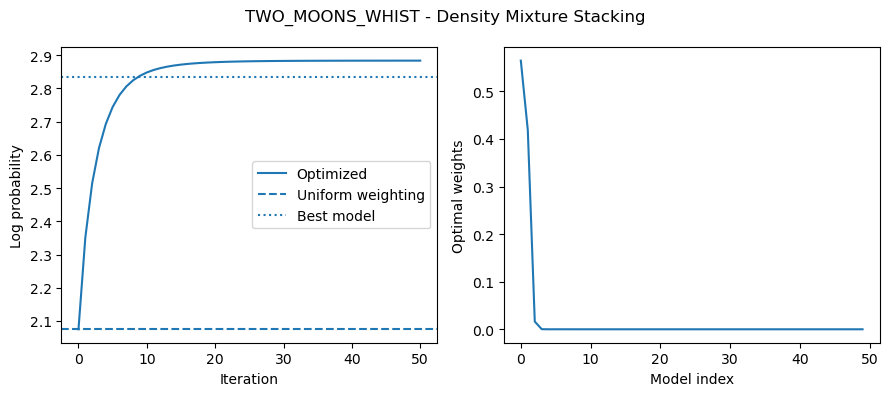

Best model:  2.8357534408569336
Uniform weighting:  2.07484769821167
Stacked model:  2.8836259841918945
Number of non-negligible weights:  3/50
Moments losses: tensor(-1.7156, device='cuda:0') tensor(-1.4102, device='cuda:0') tensor(-1.7267, device='cuda:0')
Stacking for task: slcp
slcp torch.Size([50, 1000]) torch.Size([50, 1000])


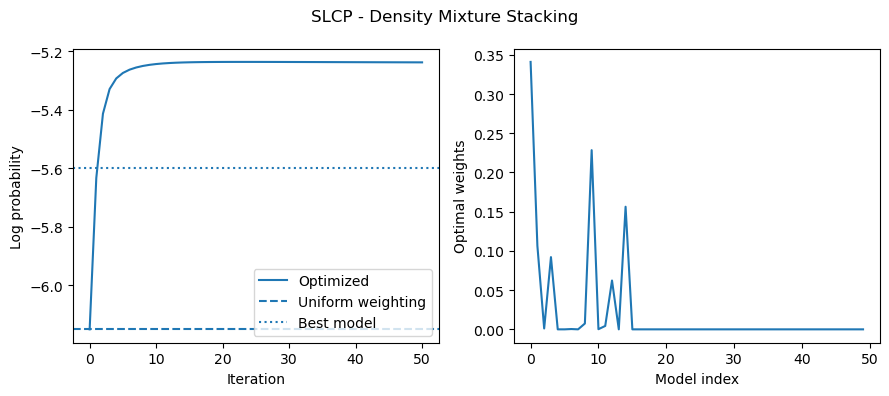

Best model:  -5.597587585449219
Uniform weighting:  -6.1508026123046875
Stacked model:  -5.237600326538086
Number of non-negligible weights:  6/50
Moments losses: tensor(1.0319, device='cuda:0') tensor(1.2497, device='cuda:0') tensor(0.9536, device='cuda:0')
Stacking for task: sir
sir torch.Size([50, 1000]) torch.Size([50, 1000])


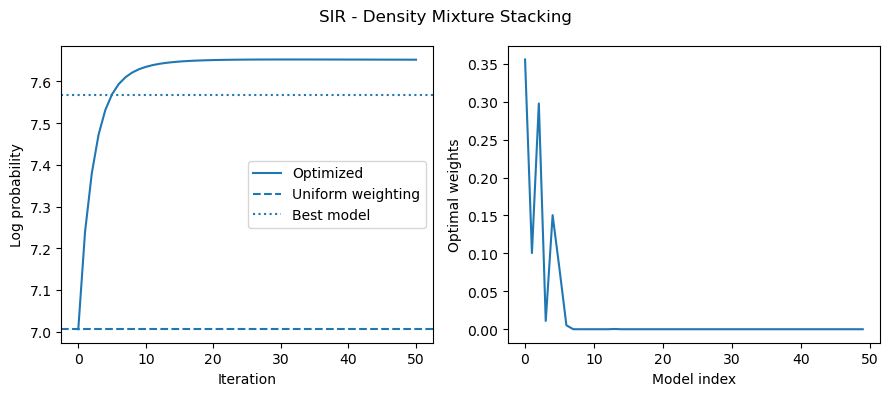

Best model:  7.566440105438232
Uniform weighting:  7.00565767288208
Stacked model:  7.652085304260254
Number of non-negligible weights:  6/50
Moments losses: tensor(-8.8563, device='cuda:0') tensor(-5.1943, device='cuda:0') tensor(-8.9013, device='cuda:0')
Stacking for task: simbig
simbig torch.Size([100, 1000]) torch.Size([100, 1000])


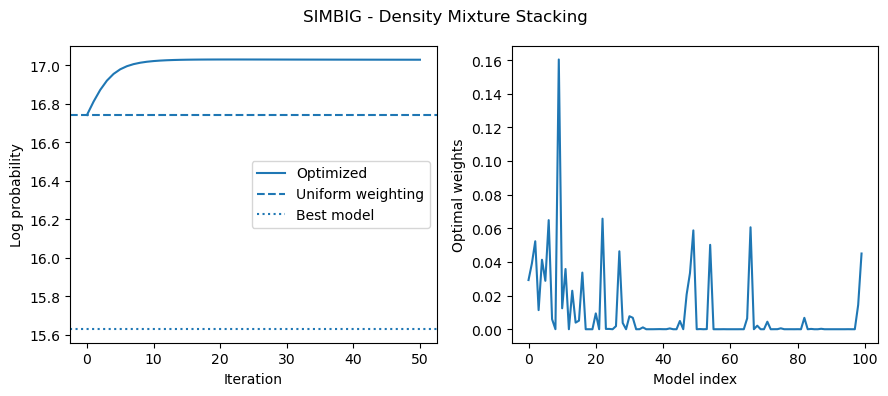

Best model:  15.629430770874023
Uniform weighting:  16.74172019958496
Stacked model:  17.0289306640625
Number of non-negligible weights:  21/100
Moments losses: tensor(-3.6731, device='cuda:0') tensor(-3.7365, device='cuda:0') tensor(-3.7959, device='cuda:0')


In [6]:
for task in tasks:
    print("Stacking for task:", task)

    if task != "simbig":
        means_train = utils.get_stats(task, "means") # shape (nb_models, nb_simulations, 2) -> mu_kn in the paper
        stds_train = utils.get_stats(task, "stds") # shape (nb_models, nb_simulations, 2) -> sqrt(v_kn) in the paper
        thetas_train = utils.get_stats(task, "theta_test") # shape (nb_simulations, 2) -> theta_n in the paper

        means_test = utils.get_stats(task, "means_v2") # shape (nb_models, nb_simulations, 2) -> mu_kn in the paper
        stds_test = utils.get_stats(task, "stds_v2") # shape (nb_models, nb_simulations, 2) -> sqrt(v_kn) in the paper
        thetas_test = utils.get_stats(task, "theta_test_v2") # shape (nb_simulations, 2) -> theta_n in the paper

        log_probs_train = utils.get_stats(task, "log_probs")
        log_probs_test = utils.get_stats(task, "log_probs_v2")
    else:
        means = utils.get_stats(task, "means") # shape (nb_models, nb_simulations, 2) -> mu_kn in the paper
        stds = utils.get_stats(task, "stds") # shape (nb_models, nb_simulations, 2) -> sqrt(v_kn) in the paper
        thetas = utils.get_stats(task, "theta_test") # shape (nb_simulations, 2) -> theta_n in the paper
        log_probs = utils.get_stats(task, "log_probs")

        randindices = torch.randperm(means.shape[1])

        means_train = means[:, randindices[:1000]]
        stds_train = stds[:, randindices[:1000]]
        thetas_train = thetas[randindices[:1000]]
        means_test = means[:, randindices[1000:]]
        stds_test = stds[:, randindices[1000:]]
        thetas_test = thetas[randindices[1000:]]

        log_probs_train = log_probs[:, randindices[:1000]]
        log_probs_test = log_probs[:, randindices[1000:]]

    print(task, log_probs_train.shape, log_probs_test.shape)
    nb_models = log_probs_train.shape[0]

    n_it = 50

    opt_weights, weights_evol = stacking.stacking_log_prob(log_probs_train,
                                                           n_it,
                                                           ret_weights_evol=True)

    # Compute evolution of log probs
    log_probs_evol = np.zeros(weights_evol.shape[0])
    for i in range(weights_evol.shape[0]):
        weights = weights_evol[i]
        log_probs_evol[i] = stacking.ensemble_log_prob(log_probs_test, weights).mean().item()

    # Compute log_probs for uniform weights
    uniform_weights = torch.ones(nb_models, device=device) / nb_models
    log_prob_unif = stacking.ensemble_log_prob(log_probs_test, uniform_weights).mean().item()

    # Plot of the evolution of the log probabilities and optimal weights
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    axs[0].plot(log_probs_evol, label='Optimized', color='C0')
    axs[0].axhline(log_prob_unif, label='Uniform weighting', color='C0', linestyle='--')
    axs[0].axhline(log_probs_test[0].mean().item(), label='Best model', color='C0', linestyle=':')
    axs[0].legend()
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Log probability')
    axs[1].plot(opt_weights.cpu().numpy())
    axs[1].set_xlabel('Model index')
    axs[1].set_ylabel('Optimal weights')
    plt.suptitle(f'{task.upper()} - Density Mixture Stacking')
    plt.tight_layout()
    plt.show()

    print("Best model: ", log_probs_test[0].mean().item())
    print("Uniform weighting: ", log_prob_unif)
    print("Stacked model: ", log_probs_evol[-1])
    print("Number of non-negligible weights: ", f"{(opt_weights > 0.01).sum().item()}/{nb_models}")

    l_stacked = stacking.moments_loss(means_test, stds_test, thetas_test, torch.log(opt_weights))
    l_unif = stacking.moments_loss(means_test, stds_test, thetas_test, torch.ones(nb_models, device=device)/nb_models)
    weights_best_model = torch.zeros(nb_models, device=device)
    weights_best_model[0] = 1e9
    l_best = stacking.moments_loss(means_test, stds_test, thetas_test, weights_best_model)
    print("Moments losses:", l_best, l_unif, l_stacked)